In [ ]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b10','b25','b50','b75'],'fi':['targets','roi','brain']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sig_100000_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_bas_data_nor_e_k5_b25_t1_0_42_n_nat_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(878801, 92)
(878801, 3)
validation
(151459, 92)
(151459, 3)
test
(112754, 92)
(112754, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 784643 (2.99 MB)


Trainable params: 784643 (2.99 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


1/9 [==>...........................] - ETA: 45s - loss: 1.2816 - STD: 0.1532 - MAE: 0.4602

2/9 [=====>........................] - ETA: 0s - loss: 1.1779 - STD: 0.1086 - MAE: 0.4477 

3/9 [=========>....................] - ETA: 0s - loss: 1.1601 - STD: 0.1214 - MAE: 0.4404

4/9 [============>.................] - ETA: 0s - loss: 1.1590 - STD: 0.1325 - MAE: 0.4357

5/9 [===============>..............] - ETA: 0s - loss: 1.1579 - STD: 0.1396 - MAE: 0.4327

6/9 [===================>..........] - ETA: 2s - loss: 1.1531 - STD: 0.1426 - MAE: 0.4307

7/9 [======================>.......] - ETA: 1s - loss: 1.1448 - STD: 0.1412 - MAE: 0.4299

8/9 [=========================>....] - ETA: 0s - loss: 1.1361 - STD: 0.1355 - MAE: 0.4300

9/9 [==============================] - ETA: 0s - loss: 1.1291 - STD: 0.1264 - MAE: 0.4307

9/9 [==============================] - 11s 692ms/step - loss: 1.1291 - STD: 0.1264 - MAE: 0.4307 - val_loss: 1.0866 - val_STD: 0.0188 - val_MAE: 0.4414


Epoch 2/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0863 - STD: 0.0189 - MAE: 0.4413

2/9 [=====>........................] - ETA: 0s - loss: 1.0922 - STD: 0.0150 - MAE: 0.4428

3/9 [=========>....................] - ETA: 0s - loss: 1.0950 - STD: 0.0157 - MAE: 0.4434

4/9 [============>.................] - ETA: 0s - loss: 1.0946 - STD: 0.0171 - MAE: 0.4432

5/9 [===============>..............] - ETA: 0s - loss: 1.0922 - STD: 0.0206 - MAE: 0.4425

6/9 [===================>..........] - ETA: 0s - loss: 1.0894 - STD: 0.0263 - MAE: 0.4415

7/9 [======================>.......] - ETA: 0s - loss: 1.0873 - STD: 0.0332 - MAE: 0.4403

8/9 [=========================>....] - ETA: 0s - loss: 1.0854 - STD: 0.0403 - MAE: 0.4390

9/9 [==============================] - ETA: 0s - loss: 1.0841 - STD: 0.0471 - MAE: 0.4379

9/9 [==============================] - 1s 110ms/step - loss: 1.0841 - STD: 0.0471 - MAE: 0.4379 - val_loss: 1.0780 - val_STD: 0.1076 - val_MAE: 0.4278


Epoch 3/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0788 - STD: 0.1077 - MAE: 0.4279

2/9 [=====>........................] - ETA: 0s - loss: 1.0799 - STD: 0.1090 - MAE: 0.4278

3/9 [=========>....................] - ETA: 0s - loss: 1.0803 - STD: 0.1091 - MAE: 0.4278

4/9 [============>.................] - ETA: 0s - loss: 1.0791 - STD: 0.1079 - MAE: 0.4278

5/9 [===============>..............] - ETA: 0s - loss: 1.0779 - STD: 0.1058 - MAE: 0.4280

6/9 [===================>..........] - ETA: 0s - loss: 1.0762 - STD: 0.1028 - MAE: 0.4283

7/9 [======================>.......] - ETA: 0s - loss: 1.0745 - STD: 0.0992 - MAE: 0.4287

8/9 [=========================>....] - ETA: 0s - loss: 1.0733 - STD: 0.0952 - MAE: 0.4291

9/9 [==============================] - ETA: 0s - loss: 1.0725 - STD: 0.0910 - MAE: 0.4297

9/9 [==============================] - 1s 107ms/step - loss: 1.0725 - STD: 0.0910 - MAE: 0.4297 - val_loss: 1.0661 - val_STD: 0.0490 - val_MAE: 0.4347


Epoch 4/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0649 - STD: 0.0495 - MAE: 0.4344

2/9 [=====>........................] - ETA: 0s - loss: 1.0650 - STD: 0.0477 - MAE: 0.4345

3/9 [=========>....................] - ETA: 0s - loss: 1.0643 - STD: 0.0474 - MAE: 0.4344

4/9 [============>.................] - ETA: 0s - loss: 1.0630 - STD: 0.0486 - MAE: 0.4340

5/9 [===============>..............] - ETA: 0s - loss: 1.0618 - STD: 0.0509 - MAE: 0.4334

6/9 [===================>..........] - ETA: 0s - loss: 1.0602 - STD: 0.0540 - MAE: 0.4326

7/9 [======================>.......] - ETA: 0s - loss: 1.0584 - STD: 0.0574 - MAE: 0.4318

8/9 [=========================>....] - ETA: 0s - loss: 1.0566 - STD: 0.0607 - MAE: 0.4308

9/9 [==============================] - ETA: 0s - loss: 1.0550 - STD: 0.0639 - MAE: 0.4299

9/9 [==============================] - 1s 111ms/step - loss: 1.0550 - STD: 0.0639 - MAE: 0.4299 - val_loss: 1.0371 - val_STD: 0.0919 - val_MAE: 0.4210


Epoch 5/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0369 - STD: 0.0926 - MAE: 0.4207

2/9 [=====>........................] - ETA: 0s - loss: 1.0342 - STD: 0.0934 - MAE: 0.4199

3/9 [=========>....................] - ETA: 0s - loss: 1.0303 - STD: 0.0938 - MAE: 0.4188

4/9 [============>.................] - ETA: 0s - loss: 1.0266 - STD: 0.0940 - MAE: 0.4179

5/9 [===============>..............] - ETA: 0s - loss: 1.0227 - STD: 0.0943 - MAE: 0.4169

6/9 [===================>..........] - ETA: 0s - loss: 1.0184 - STD: 0.0947 - MAE: 0.4157

7/9 [======================>.......] - ETA: 0s - loss: 1.0139 - STD: 0.0955 - MAE: 0.4145

8/9 [=========================>....] - ETA: 0s - loss: 1.0092 - STD: 0.0967 - MAE: 0.4131

9/9 [==============================] - ETA: 0s - loss: 1.0055 - STD: 0.0985 - MAE: 0.4117

9/9 [==============================] - 1s 105ms/step - loss: 1.0055 - STD: 0.0985 - MAE: 0.4117 - val_loss: 0.9646 - val_STD: 0.1224 - val_MAE: 0.3970


Epoch 6/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.9579 - STD: 0.1230 - MAE: 0.3953

2/9 [=====>........................] - ETA: 0s - loss: 0.9525 - STD: 0.1290 - MAE: 0.3925

3/9 [=========>....................] - ETA: 0s - loss: 0.9476 - STD: 0.1355 - MAE: 0.3896

4/9 [============>.................] - ETA: 0s - loss: 0.9436 - STD: 0.1421 - MAE: 0.3867

5/9 [===============>..............] - ETA: 0s - loss: 0.9406 - STD: 0.1486 - MAE: 0.3841

6/9 [===================>..........] - ETA: 0s - loss: 0.9380 - STD: 0.1549 - MAE: 0.3816

7/9 [======================>.......] - ETA: 0s - loss: 0.9354 - STD: 0.1609 - MAE: 0.3790

8/9 [=========================>....] - ETA: 0s - loss: 0.9337 - STD: 0.1662 - MAE: 0.3767

9/9 [==============================] - ETA: 0s - loss: 0.9315 - STD: 0.1708 - MAE: 0.3747

9/9 [==============================] - 1s 110ms/step - loss: 0.9315 - STD: 0.1708 - MAE: 0.3747 - val_loss: 0.9348 - val_STD: 0.2118 - val_MAE: 0.3604


Epoch 7/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.9117 - STD: 0.2107 - MAE: 0.3564

2/9 [=====>........................] - ETA: 0s - loss: 0.9102 - STD: 0.2110 - MAE: 0.3560

3/9 [=========>....................] - ETA: 0s - loss: 0.9093 - STD: 0.2107 - MAE: 0.3559

4/9 [============>.................] - ETA: 0s - loss: 0.9089 - STD: 0.2097 - MAE: 0.3562

5/9 [===============>..............] - ETA: 0s - loss: 0.9077 - STD: 0.2088 - MAE: 0.3563

6/9 [===================>..........] - ETA: 0s - loss: 0.9064 - STD: 0.2079 - MAE: 0.3563

7/9 [======================>.......] - ETA: 0s - loss: 0.9052 - STD: 0.2064 - MAE: 0.3567

8/9 [=========================>....] - ETA: 0s - loss: 0.9034 - STD: 0.2051 - MAE: 0.3569

9/9 [==============================] - ETA: 0s - loss: 0.9022 - STD: 0.2045 - MAE: 0.3569

9/9 [==============================] - 1s 106ms/step - loss: 0.9022 - STD: 0.2045 - MAE: 0.3569 - val_loss: 0.9070 - val_STD: 0.2070 - val_MAE: 0.3567


Epoch 8/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8914 - STD: 0.1984 - MAE: 0.3575

2/9 [=====>........................] - ETA: 0s - loss: 0.8883 - STD: 0.1967 - MAE: 0.3575

3/9 [=========>....................] - ETA: 0s - loss: 0.8881 - STD: 0.1983 - MAE: 0.3569

4/9 [============>.................] - ETA: 0s - loss: 0.8876 - STD: 0.1988 - MAE: 0.3566

5/9 [===============>..............] - ETA: 0s - loss: 0.8867 - STD: 0.1991 - MAE: 0.3563

6/9 [===================>..........] - ETA: 0s - loss: 0.8862 - STD: 0.1999 - MAE: 0.3558

7/9 [======================>.......] - ETA: 0s - loss: 0.8849 - STD: 0.2002 - MAE: 0.3555

8/9 [=========================>....] - ETA: 0s - loss: 0.8833 - STD: 0.2008 - MAE: 0.3549

9/9 [==============================] - ETA: 0s - loss: 0.8820 - STD: 0.2018 - MAE: 0.3542

9/9 [==============================] - 1s 110ms/step - loss: 0.8820 - STD: 0.2018 - MAE: 0.3542 - val_loss: 0.8967 - val_STD: 0.2250 - val_MAE: 0.3466


Epoch 9/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8757 - STD: 0.2071 - MAE: 0.3507

2/9 [=====>........................] - ETA: 0s - loss: 0.8737 - STD: 0.2089 - MAE: 0.3493

3/9 [=========>....................] - ETA: 0s - loss: 0.8727 - STD: 0.2117 - MAE: 0.3479

4/9 [============>.................] - ETA: 0s - loss: 0.8710 - STD: 0.2121 - MAE: 0.3474

5/9 [===============>..............] - ETA: 0s - loss: 0.8702 - STD: 0.2143 - MAE: 0.3463

6/9 [===================>..........] - ETA: 0s - loss: 0.8691 - STD: 0.2144 - MAE: 0.3460

7/9 [======================>.......] - ETA: 0s - loss: 0.8687 - STD: 0.2155 - MAE: 0.3455

8/9 [=========================>....] - ETA: 0s - loss: 0.8678 - STD: 0.2157 - MAE: 0.3453

9/9 [==============================] - ETA: 0s - loss: 0.8671 - STD: 0.2157 - MAE: 0.3451

9/9 [==============================] - 1s 104ms/step - loss: 0.8671 - STD: 0.2157 - MAE: 0.3451 - val_loss: 0.8893 - val_STD: 0.2434 - val_MAE: 0.3367


Epoch 10/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8609 - STD: 0.2192 - MAE: 0.3424

2/9 [=====>........................] - ETA: 0s - loss: 0.8600 - STD: 0.2162 - MAE: 0.3435

3/9 [=========>....................] - ETA: 0s - loss: 0.8588 - STD: 0.2165 - MAE: 0.3431

4/9 [============>.................] - ETA: 0s - loss: 0.8587 - STD: 0.2181 - MAE: 0.3424

5/9 [===============>..............] - ETA: 0s - loss: 0.8582 - STD: 0.2173 - MAE: 0.3426

6/9 [===================>..........] - ETA: 0s - loss: 0.8576 - STD: 0.2184 - MAE: 0.3420

7/9 [======================>.......] - ETA: 0s - loss: 0.8567 - STD: 0.2196 - MAE: 0.3413

8/9 [=========================>....] - ETA: 0s - loss: 0.8568 - STD: 0.2194 - MAE: 0.3415

9/9 [==============================] - ETA: 0s - loss: 0.8568 - STD: 0.2205 - MAE: 0.3410

9/9 [==============================] - 1s 104ms/step - loss: 0.8568 - STD: 0.2205 - MAE: 0.3410 - val_loss: 0.8751 - val_STD: 0.2490 - val_MAE: 0.3309


Epoch 11/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8514 - STD: 0.2244 - MAE: 0.3382

2/9 [=====>........................] - ETA: 0s - loss: 0.8527 - STD: 0.2225 - MAE: 0.3393

3/9 [=========>....................] - ETA: 0s - loss: 0.8510 - STD: 0.2256 - MAE: 0.3375

4/9 [============>.................] - ETA: 0s - loss: 0.8498 - STD: 0.2257 - MAE: 0.3372

5/9 [===============>..............] - ETA: 0s - loss: 0.8495 - STD: 0.2252 - MAE: 0.3374

6/9 [===================>..........] - ETA: 0s - loss: 0.8492 - STD: 0.2261 - MAE: 0.3369

7/9 [======================>.......] - ETA: 0s - loss: 0.8492 - STD: 0.2266 - MAE: 0.3367

8/9 [=========================>....] - ETA: 0s - loss: 0.8491 - STD: 0.2265 - MAE: 0.3368

9/9 [==============================] - ETA: 0s - loss: 0.8483 - STD: 0.2273 - MAE: 0.3363

9/9 [==============================] - 1s 105ms/step - loss: 0.8483 - STD: 0.2273 - MAE: 0.3363 - val_loss: 0.8683 - val_STD: 0.2564 - val_MAE: 0.3260


Epoch 12/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8427 - STD: 0.2323 - MAE: 0.3330

2/9 [=====>........................] - ETA: 0s - loss: 0.8440 - STD: 0.2281 - MAE: 0.3351

3/9 [=========>....................] - ETA: 0s - loss: 0.8441 - STD: 0.2304 - MAE: 0.3341

4/9 [============>.................] - ETA: 0s - loss: 0.8439 - STD: 0.2309 - MAE: 0.3338

5/9 [===============>..............] - ETA: 0s - loss: 0.8437 - STD: 0.2298 - MAE: 0.3343

6/9 [===================>..........] - ETA: 0s - loss: 0.8436 - STD: 0.2310 - MAE: 0.3338

7/9 [======================>.......] - ETA: 0s - loss: 0.8430 - STD: 0.2315 - MAE: 0.3334

8/9 [=========================>....] - ETA: 0s - loss: 0.8426 - STD: 0.2311 - MAE: 0.3335

9/9 [==============================] - ETA: 0s - loss: 0.8422 - STD: 0.2314 - MAE: 0.3333

9/9 [==============================] - 1s 108ms/step - loss: 0.8422 - STD: 0.2314 - MAE: 0.3333 - val_loss: 0.8593 - val_STD: 0.2582 - val_MAE: 0.3235


Epoch 13/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8375 - STD: 0.2369 - MAE: 0.3298

2/9 [=====>........................] - ETA: 0s - loss: 0.8382 - STD: 0.2338 - MAE: 0.3315

3/9 [=========>....................] - ETA: 0s - loss: 0.8382 - STD: 0.2332 - MAE: 0.3318

4/9 [============>.................] - ETA: 0s - loss: 0.8386 - STD: 0.2346 - MAE: 0.3312

5/9 [===============>..............] - ETA: 0s - loss: 0.8378 - STD: 0.2344 - MAE: 0.3311

6/9 [===================>..........] - ETA: 0s - loss: 0.8377 - STD: 0.2342 - MAE: 0.3312

7/9 [======================>.......] - ETA: 0s - loss: 0.8372 - STD: 0.2346 - MAE: 0.3309

8/9 [=========================>....] - ETA: 0s - loss: 0.8370 - STD: 0.2347 - MAE: 0.3309

9/9 [==============================] - ETA: 0s - loss: 0.8367 - STD: 0.2346 - MAE: 0.3309

9/9 [==============================] - 1s 107ms/step - loss: 0.8367 - STD: 0.2346 - MAE: 0.3309 - val_loss: 0.8492 - val_STD: 0.2570 - val_MAE: 0.3223


Epoch 14/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8340 - STD: 0.2372 - MAE: 0.3293

2/9 [=====>........................] - ETA: 0s - loss: 0.8336 - STD: 0.2379 - MAE: 0.3288

3/9 [=========>....................] - ETA: 0s - loss: 0.8342 - STD: 0.2365 - MAE: 0.3296

4/9 [============>.................] - ETA: 0s - loss: 0.8338 - STD: 0.2368 - MAE: 0.3294

5/9 [===============>..............] - ETA: 0s - loss: 0.8335 - STD: 0.2374 - MAE: 0.3290

6/9 [===================>..........] - ETA: 0s - loss: 0.8330 - STD: 0.2370 - MAE: 0.3291

7/9 [======================>.......] - ETA: 0s - loss: 0.8330 - STD: 0.2373 - MAE: 0.3290

8/9 [=========================>....] - ETA: 0s - loss: 0.8324 - STD: 0.2375 - MAE: 0.3288

9/9 [==============================] - ETA: 0s - loss: 0.8321 - STD: 0.2377 - MAE: 0.3286

9/9 [==============================] - 1s 108ms/step - loss: 0.8321 - STD: 0.2377 - MAE: 0.3286 - val_loss: 0.8427 - val_STD: 0.2580 - val_MAE: 0.3207


Epoch 15/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8296 - STD: 0.2402 - MAE: 0.3270

2/9 [=====>........................] - ETA: 0s - loss: 0.8308 - STD: 0.2402 - MAE: 0.3273

3/9 [=========>....................] - ETA: 0s - loss: 0.8293 - STD: 0.2390 - MAE: 0.3275

4/9 [============>.................] - ETA: 0s - loss: 0.8289 - STD: 0.2387 - MAE: 0.3275

5/9 [===============>..............] - ETA: 0s - loss: 0.8289 - STD: 0.2389 - MAE: 0.3274

6/9 [===================>..........] - ETA: 0s - loss: 0.8291 - STD: 0.2387 - MAE: 0.3276

7/9 [======================>.......] - ETA: 0s - loss: 0.8287 - STD: 0.2392 - MAE: 0.3273

8/9 [=========================>....] - ETA: 0s - loss: 0.8284 - STD: 0.2395 - MAE: 0.3271

9/9 [==============================] - ETA: 0s - loss: 0.8278 - STD: 0.2397 - MAE: 0.3269

9/9 [==============================] - 1s 107ms/step - loss: 0.8278 - STD: 0.2397 - MAE: 0.3269 - val_loss: 0.8385 - val_STD: 0.2597 - val_MAE: 0.3191


Epoch 16/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.8278 - STD: 0.2425 - MAE: 0.3256

2/9 [=====>........................] - ETA: 0s - loss: 0.8268 - STD: 0.2404 - MAE: 0.3265

3/9 [=========>....................] - ETA: 0s - loss: 0.8254 - STD: 0.2405 - MAE: 0.3261

4/9 [============>.................] - ETA: 0s - loss: 0.8250 - STD: 0.2413 - MAE: 0.3257

5/9 [===============>..............] - ETA: 0s - loss: 0.8252 - STD: 0.2413 - MAE: 0.3257

6/9 [===================>..........] - ETA: 0s - loss: 0.8248 - STD: 0.2413 - MAE: 0.3256

7/9 [======================>.......] - ETA: 0s - loss: 0.8245 - STD: 0.2420 - MAE: 0.3252

8/9 [=========================>....] - ETA: 0s - loss: 0.8237 - STD: 0.2419 - MAE: 0.3251

9/9 [==============================] - ETA: 0s - loss: 0.8231 - STD: 0.2417 - MAE: 0.3250

9/9 [==============================] - 1s 106ms/step - loss: 0.8231 - STD: 0.2417 - MAE: 0.3250 - val_loss: 0.8352 - val_STD: 0.2624 - val_MAE: 0.3172


Epoch 17/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8182 - STD: 0.2471 - MAE: 0.3215

2/9 [=====>........................] - ETA: 0s - loss: 0.8206 - STD: 0.2450 - MAE: 0.3229

3/9 [=========>....................] - ETA: 0s - loss: 0.8199 - STD: 0.2435 - MAE: 0.3235

4/9 [============>.................] - ETA: 0s - loss: 0.8200 - STD: 0.2444 - MAE: 0.3231

5/9 [===============>..............] - ETA: 0s - loss: 0.8189 - STD: 0.2440 - MAE: 0.3231

6/9 [===================>..........] - ETA: 0s - loss: 0.8187 - STD: 0.2443 - MAE: 0.3229

7/9 [======================>.......] - ETA: 0s - loss: 0.8186 - STD: 0.2443 - MAE: 0.3229

8/9 [=========================>....] - ETA: 0s - loss: 0.8179 - STD: 0.2444 - MAE: 0.3227

9/9 [==============================] - ETA: 0s - loss: 0.8177 - STD: 0.2450 - MAE: 0.3223

9/9 [==============================] - 1s 102ms/step - loss: 0.8177 - STD: 0.2450 - MAE: 0.3223 - val_loss: 0.8241 - val_STD: 0.2553 - val_MAE: 0.3186


Epoch 18/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8160 - STD: 0.2407 - MAE: 0.3240

2/9 [=====>........................] - ETA: 0s - loss: 0.8148 - STD: 0.2423 - MAE: 0.3230

3/9 [=========>....................] - ETA: 0s - loss: 0.8145 - STD: 0.2447 - MAE: 0.3218

4/9 [============>.................] - ETA: 0s - loss: 0.8136 - STD: 0.2447 - MAE: 0.3216

5/9 [===============>..............] - ETA: 0s - loss: 0.8138 - STD: 0.2456 - MAE: 0.3212

6/9 [===================>..........] - ETA: 0s - loss: 0.8133 - STD: 0.2456 - MAE: 0.3211

7/9 [======================>.......] - ETA: 0s - loss: 0.8125 - STD: 0.2456 - MAE: 0.3209

8/9 [=========================>....] - ETA: 0s - loss: 0.8117 - STD: 0.2461 - MAE: 0.3205

9/9 [==============================] - ETA: 0s - loss: 0.8114 - STD: 0.2463 - MAE: 0.3203

9/9 [==============================] - 1s 103ms/step - loss: 0.8114 - STD: 0.2463 - MAE: 0.3203 - val_loss: 0.8203 - val_STD: 0.2595 - val_MAE: 0.3157


Epoch 19/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8109 - STD: 0.2466 - MAE: 0.3201

2/9 [=====>........................] - ETA: 0s - loss: 0.8079 - STD: 0.2485 - MAE: 0.3186

3/9 [=========>....................] - ETA: 0s - loss: 0.8073 - STD: 0.2485 - MAE: 0.3184

4/9 [============>.................] - ETA: 0s - loss: 0.8067 - STD: 0.2486 - MAE: 0.3183

5/9 [===============>..............] - ETA: 0s - loss: 0.8063 - STD: 0.2498 - MAE: 0.3176

6/9 [===================>..........] - ETA: 0s - loss: 0.8064 - STD: 0.2493 - MAE: 0.3178

7/9 [======================>.......] - ETA: 0s - loss: 0.8056 - STD: 0.2493 - MAE: 0.3176

8/9 [=========================>....] - ETA: 0s - loss: 0.8054 - STD: 0.2496 - MAE: 0.3175

9/9 [==============================] - ETA: 0s - loss: 0.8049 - STD: 0.2497 - MAE: 0.3173

9/9 [==============================] - 1s 101ms/step - loss: 0.8049 - STD: 0.2497 - MAE: 0.3173 - val_loss: 0.8208 - val_STD: 0.2660 - val_MAE: 0.3123


Epoch 20/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8019 - STD: 0.2552 - MAE: 0.3138

2/9 [=====>........................] - ETA: 0s - loss: 0.8026 - STD: 0.2531 - MAE: 0.3150

3/9 [=========>....................] - ETA: 0s - loss: 0.8012 - STD: 0.2525 - MAE: 0.3150

4/9 [============>.................] - ETA: 0s - loss: 0.8000 - STD: 0.2534 - MAE: 0.3143

5/9 [===============>..............] - ETA: 0s - loss: 0.7998 - STD: 0.2533 - MAE: 0.3143

6/9 [===================>..........] - ETA: 0s - loss: 0.8000 - STD: 0.2534 - MAE: 0.3143

7/9 [======================>.......] - ETA: 0s - loss: 0.8002 - STD: 0.2534 - MAE: 0.3143

8/9 [=========================>....] - ETA: 0s - loss: 0.7999 - STD: 0.2533 - MAE: 0.3144

9/9 [==============================] - ETA: 0s - loss: 0.7997 - STD: 0.2533 - MAE: 0.3143

9/9 [==============================] - 1s 105ms/step - loss: 0.7997 - STD: 0.2533 - MAE: 0.3143 - val_loss: 0.8137 - val_STD: 0.2627 - val_MAE: 0.3126


Epoch 21/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7950 - STD: 0.2522 - MAE: 0.3138

2/9 [=====>........................] - ETA: 0s - loss: 0.7954 - STD: 0.2535 - MAE: 0.3132

3/9 [=========>....................] - ETA: 0s - loss: 0.7953 - STD: 0.2545 - MAE: 0.3127

4/9 [============>.................] - ETA: 0s - loss: 0.7951 - STD: 0.2546 - MAE: 0.3127

5/9 [===============>..............] - ETA: 0s - loss: 0.7951 - STD: 0.2550 - MAE: 0.3125

6/9 [===================>..........] - ETA: 0s - loss: 0.7946 - STD: 0.2554 - MAE: 0.3122

7/9 [======================>.......] - ETA: 0s - loss: 0.7949 - STD: 0.2554 - MAE: 0.3123

8/9 [=========================>....] - ETA: 0s - loss: 0.7949 - STD: 0.2553 - MAE: 0.3123

9/9 [==============================] - ETA: 0s - loss: 0.7950 - STD: 0.2555 - MAE: 0.3122

9/9 [==============================] - 1s 111ms/step - loss: 0.7950 - STD: 0.2555 - MAE: 0.3122 - val_loss: 0.8087 - val_STD: 0.2650 - val_MAE: 0.3105


Epoch 22/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7923 - STD: 0.2540 - MAE: 0.3124

2/9 [=====>........................] - ETA: 0s - loss: 0.7919 - STD: 0.2543 - MAE: 0.3122

3/9 [=========>....................] - ETA: 0s - loss: 0.7906 - STD: 0.2550 - MAE: 0.3116

4/9 [============>.................] - ETA: 0s - loss: 0.7908 - STD: 0.2562 - MAE: 0.3110

5/9 [===============>..............] - ETA: 0s - loss: 0.7910 - STD: 0.2565 - MAE: 0.3109

6/9 [===================>..........] - ETA: 0s - loss: 0.7915 - STD: 0.2564 - MAE: 0.3111

7/9 [======================>.......] - ETA: 0s - loss: 0.7915 - STD: 0.2571 - MAE: 0.3107

8/9 [=========================>....] - ETA: 0s - loss: 0.7917 - STD: 0.2569 - MAE: 0.3109

9/9 [==============================] - ETA: 0s - loss: 0.7912 - STD: 0.2566 - MAE: 0.3109

9/9 [==============================] - 1s 107ms/step - loss: 0.7912 - STD: 0.2566 - MAE: 0.3109 - val_loss: 0.8055 - val_STD: 0.2695 - val_MAE: 0.3075


Epoch 23/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7871 - STD: 0.2577 - MAE: 0.3095

2/9 [=====>........................] - ETA: 0s - loss: 0.7876 - STD: 0.2579 - MAE: 0.3096

3/9 [=========>....................] - ETA: 0s - loss: 0.7869 - STD: 0.2576 - MAE: 0.3095

4/9 [============>.................] - ETA: 0s - loss: 0.7865 - STD: 0.2580 - MAE: 0.3093

5/9 [===============>..............] - ETA: 0s - loss: 0.7868 - STD: 0.2592 - MAE: 0.3087

6/9 [===================>..........] - ETA: 0s - loss: 0.7870 - STD: 0.2590 - MAE: 0.3089

7/9 [======================>.......] - ETA: 0s - loss: 0.7871 - STD: 0.2592 - MAE: 0.3088

8/9 [=========================>....] - ETA: 0s - loss: 0.7871 - STD: 0.2592 - MAE: 0.3088

9/9 [==============================] - ETA: 0s - loss: 0.7869 - STD: 0.2593 - MAE: 0.3088

9/9 [==============================] - 1s 113ms/step - loss: 0.7869 - STD: 0.2593 - MAE: 0.3088 - val_loss: 0.8022 - val_STD: 0.2706 - val_MAE: 0.3065


Epoch 24/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7825 - STD: 0.2573 - MAE: 0.3087

2/9 [=====>........................] - ETA: 0s - loss: 0.7835 - STD: 0.2577 - MAE: 0.3088

3/9 [=========>....................] - ETA: 0s - loss: 0.7829 - STD: 0.2588 - MAE: 0.3082

4/9 [============>.................] - ETA: 0s - loss: 0.7829 - STD: 0.2591 - MAE: 0.3081

5/9 [===============>..............] - ETA: 0s - loss: 0.7827 - STD: 0.2594 - MAE: 0.3079

6/9 [===================>..........] - ETA: 0s - loss: 0.7828 - STD: 0.2598 - MAE: 0.3077

7/9 [======================>.......] - ETA: 0s - loss: 0.7830 - STD: 0.2606 - MAE: 0.3074

8/9 [=========================>....] - ETA: 0s - loss: 0.7840 - STD: 0.2601 - MAE: 0.3078

9/9 [==============================] - ETA: 0s - loss: 0.7850 - STD: 0.2606 - MAE: 0.3078

9/9 [==============================] - 1s 111ms/step - loss: 0.7850 - STD: 0.2606 - MAE: 0.3078 - val_loss: 0.7956 - val_STD: 0.2743 - val_MAE: 0.3032


Epoch 25/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7825 - STD: 0.2605 - MAE: 0.3074

2/9 [=====>........................] - ETA: 0s - loss: 0.7835 - STD: 0.2594 - MAE: 0.3082

3/9 [=========>....................] - ETA: 0s - loss: 0.7860 - STD: 0.2613 - MAE: 0.3077

4/9 [============>.................] - ETA: 0s - loss: 0.7837 - STD: 0.2606 - MAE: 0.3076

5/9 [===============>..............] - ETA: 0s - loss: 0.7837 - STD: 0.2610 - MAE: 0.3074

6/9 [===================>..........] - ETA: 0s - loss: 0.7836 - STD: 0.2621 - MAE: 0.3068

7/9 [======================>.......] - ETA: 0s - loss: 0.7830 - STD: 0.2617 - MAE: 0.3069

8/9 [=========================>....] - ETA: 0s - loss: 0.7837 - STD: 0.2616 - MAE: 0.3071

9/9 [==============================] - ETA: 0s - loss: 0.7838 - STD: 0.2623 - MAE: 0.3068

9/9 [==============================] - 1s 106ms/step - loss: 0.7838 - STD: 0.2623 - MAE: 0.3068 - val_loss: 0.8003 - val_STD: 0.2751 - val_MAE: 0.3041


Epoch 26/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7824 - STD: 0.2596 - MAE: 0.3079

2/9 [=====>........................] - ETA: 0s - loss: 0.7835 - STD: 0.2571 - MAE: 0.3094

3/9 [=========>....................] - ETA: 0s - loss: 0.7829 - STD: 0.2600 - MAE: 0.3078

4/9 [============>.................] - ETA: 0s - loss: 0.7821 - STD: 0.2616 - MAE: 0.3068

5/9 [===============>..............] - ETA: 0s - loss: 0.7816 - STD: 0.2602 - MAE: 0.3075

6/9 [===================>..........] - ETA: 0s - loss: 0.7808 - STD: 0.2600 - MAE: 0.3074

7/9 [======================>.......] - ETA: 0s - loss: 0.7809 - STD: 0.2617 - MAE: 0.3066

8/9 [=========================>....] - ETA: 0s - loss: 0.7803 - STD: 0.2616 - MAE: 0.3065

9/9 [==============================] - ETA: 0s - loss: 0.7801 - STD: 0.2610 - MAE: 0.3068

9/9 [==============================] - 1s 109ms/step - loss: 0.7801 - STD: 0.2610 - MAE: 0.3068 - val_loss: 0.7937 - val_STD: 0.2812 - val_MAE: 0.2994


Epoch 27/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7752 - STD: 0.2661 - MAE: 0.3033

2/9 [=====>........................] - ETA: 0s - loss: 0.7752 - STD: 0.2678 - MAE: 0.3023

3/9 [=========>....................] - ETA: 0s - loss: 0.7770 - STD: 0.2649 - MAE: 0.3042

4/9 [============>.................] - ETA: 0s - loss: 0.7762 - STD: 0.2632 - MAE: 0.3049

5/9 [===============>..............] - ETA: 0s - loss: 0.7758 - STD: 0.2639 - MAE: 0.3044

6/9 [===================>..........] - ETA: 0s - loss: 0.7758 - STD: 0.2640 - MAE: 0.3044

7/9 [======================>.......] - ETA: 0s - loss: 0.7756 - STD: 0.2635 - MAE: 0.3046

8/9 [=========================>....] - ETA: 0s - loss: 0.7751 - STD: 0.2635 - MAE: 0.3045

9/9 [==============================] - ETA: 0s - loss: 0.7749 - STD: 0.2638 - MAE: 0.3043

9/9 [==============================] - 1s 111ms/step - loss: 0.7749 - STD: 0.2638 - MAE: 0.3043 - val_loss: 0.7872 - val_STD: 0.2796 - val_MAE: 0.2990


Epoch 28/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7726 - STD: 0.2638 - MAE: 0.3040

2/9 [=====>........................] - ETA: 0s - loss: 0.7716 - STD: 0.2636 - MAE: 0.3039

3/9 [=========>....................] - ETA: 0s - loss: 0.7726 - STD: 0.2638 - MAE: 0.3040

4/9 [============>.................] - ETA: 0s - loss: 0.7726 - STD: 0.2643 - MAE: 0.3037

5/9 [===============>..............] - ETA: 0s - loss: 0.7727 - STD: 0.2643 - MAE: 0.3037

6/9 [===================>..........] - ETA: 0s - loss: 0.7726 - STD: 0.2643 - MAE: 0.3037

7/9 [======================>.......] - ETA: 0s - loss: 0.7726 - STD: 0.2645 - MAE: 0.3036

8/9 [=========================>....] - ETA: 0s - loss: 0.7724 - STD: 0.2646 - MAE: 0.3035

9/9 [==============================] - ETA: 0s - loss: 0.7717 - STD: 0.2646 - MAE: 0.3034

9/9 [==============================] - 1s 109ms/step - loss: 0.7717 - STD: 0.2646 - MAE: 0.3034 - val_loss: 0.7863 - val_STD: 0.2829 - val_MAE: 0.2972


Epoch 29/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7735 - STD: 0.2670 - MAE: 0.3025

2/9 [=====>........................] - ETA: 0s - loss: 0.7715 - STD: 0.2666 - MAE: 0.3023

3/9 [=========>....................] - ETA: 0s - loss: 0.7720 - STD: 0.2659 - MAE: 0.3028

4/9 [============>.................] - ETA: 0s - loss: 0.7702 - STD: 0.2659 - MAE: 0.3025

5/9 [===============>..............] - ETA: 0s - loss: 0.7699 - STD: 0.2661 - MAE: 0.3023

6/9 [===================>..........] - ETA: 0s - loss: 0.7701 - STD: 0.2661 - MAE: 0.3023

7/9 [======================>.......] - ETA: 0s - loss: 0.7698 - STD: 0.2658 - MAE: 0.3024

8/9 [=========================>....] - ETA: 0s - loss: 0.7698 - STD: 0.2656 - MAE: 0.3026

9/9 [==============================] - ETA: 0s - loss: 0.7692 - STD: 0.2655 - MAE: 0.3024

9/9 [==============================] - 1s 109ms/step - loss: 0.7692 - STD: 0.2655 - MAE: 0.3024 - val_loss: 0.7815 - val_STD: 0.2808 - val_MAE: 0.2976


Epoch 30/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7647 - STD: 0.2653 - MAE: 0.3018

2/9 [=====>........................] - ETA: 0s - loss: 0.7661 - STD: 0.2656 - MAE: 0.3018

3/9 [=========>....................] - ETA: 0s - loss: 0.7667 - STD: 0.2663 - MAE: 0.3016

4/9 [============>.................] - ETA: 0s - loss: 0.7673 - STD: 0.2660 - MAE: 0.3018

5/9 [===============>..............] - ETA: 0s - loss: 0.7669 - STD: 0.2661 - MAE: 0.3017

6/9 [===================>..........] - ETA: 0s - loss: 0.7670 - STD: 0.2665 - MAE: 0.3015

7/9 [======================>.......] - ETA: 0s - loss: 0.7672 - STD: 0.2665 - MAE: 0.3016

8/9 [=========================>....] - ETA: 0s - loss: 0.7667 - STD: 0.2665 - MAE: 0.3015

9/9 [==============================] - ETA: 0s - loss: 0.7666 - STD: 0.2667 - MAE: 0.3014

9/9 [==============================] - 1s 109ms/step - loss: 0.7666 - STD: 0.2667 - MAE: 0.3014 - val_loss: 0.7770 - val_STD: 0.2825 - val_MAE: 0.2957


Epoch 31/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7636 - STD: 0.2676 - MAE: 0.3004

2/9 [=====>........................] - ETA: 0s - loss: 0.7631 - STD: 0.2675 - MAE: 0.3002

3/9 [=========>....................] - ETA: 0s - loss: 0.7640 - STD: 0.2675 - MAE: 0.3004

4/9 [============>.................] - ETA: 0s - loss: 0.7644 - STD: 0.2670 - MAE: 0.3008

5/9 [===============>..............] - ETA: 0s - loss: 0.7647 - STD: 0.2670 - MAE: 0.3009

6/9 [===================>..........] - ETA: 0s - loss: 0.7646 - STD: 0.2672 - MAE: 0.3008

7/9 [======================>.......] - ETA: 0s - loss: 0.7644 - STD: 0.2669 - MAE: 0.3009

8/9 [=========================>....] - ETA: 0s - loss: 0.7642 - STD: 0.2668 - MAE: 0.3009

9/9 [==============================] - ETA: 0s - loss: 0.7637 - STD: 0.2670 - MAE: 0.3007

9/9 [==============================] - 1s 109ms/step - loss: 0.7637 - STD: 0.2670 - MAE: 0.3007 - val_loss: 0.7747 - val_STD: 0.2839 - val_MAE: 0.2946


Epoch 32/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7609 - STD: 0.2682 - MAE: 0.2994

2/9 [=====>........................] - ETA: 0s - loss: 0.7626 - STD: 0.2678 - MAE: 0.3000

3/9 [=========>....................] - ETA: 0s - loss: 0.7628 - STD: 0.2684 - MAE: 0.2998

4/9 [============>.................] - ETA: 0s - loss: 0.7627 - STD: 0.2682 - MAE: 0.2999

5/9 [===============>..............] - ETA: 0s - loss: 0.7618 - STD: 0.2682 - MAE: 0.2998

6/9 [===================>..........] - ETA: 0s - loss: 0.7617 - STD: 0.2683 - MAE: 0.2997

7/9 [======================>.......] - ETA: 0s - loss: 0.7616 - STD: 0.2681 - MAE: 0.2998

8/9 [=========================>....] - ETA: 0s - loss: 0.7612 - STD: 0.2680 - MAE: 0.2997

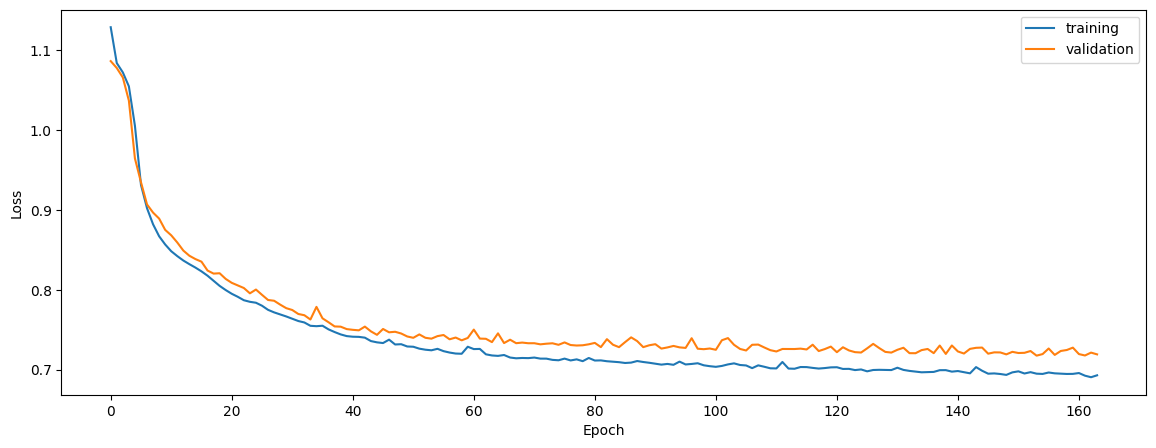

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.6935347137747909


0.6799860028126423


0.7030970076449616


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.736240870719909


0.7067356807191991


0.7386030852952706


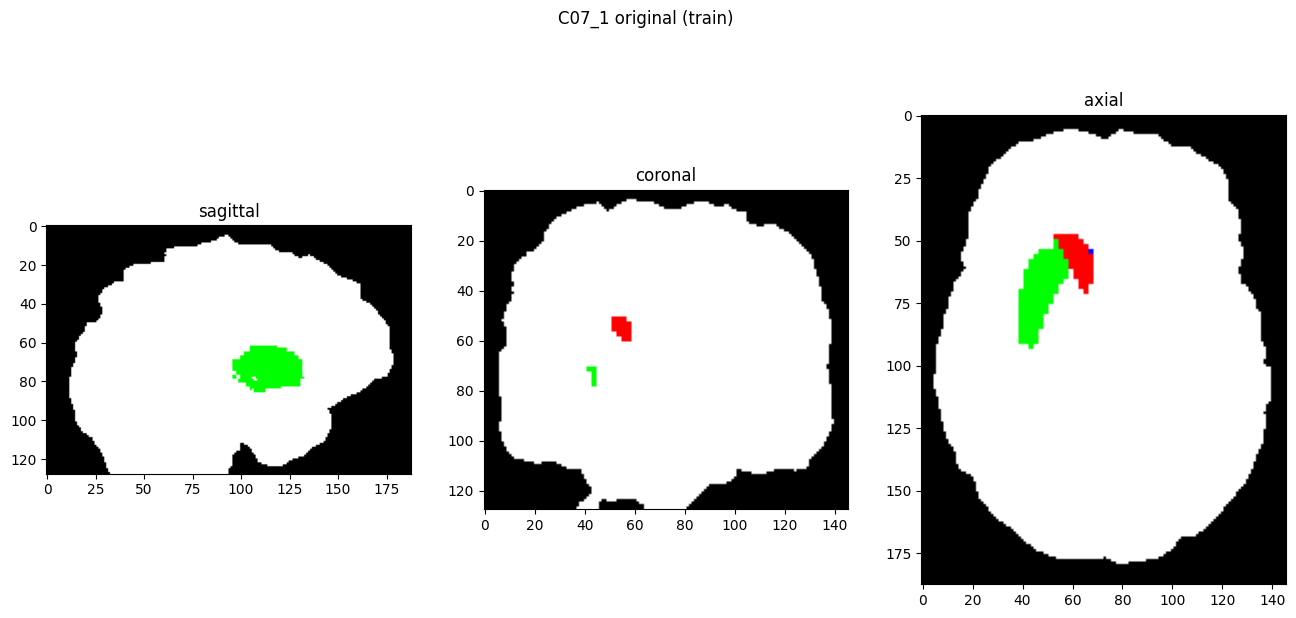

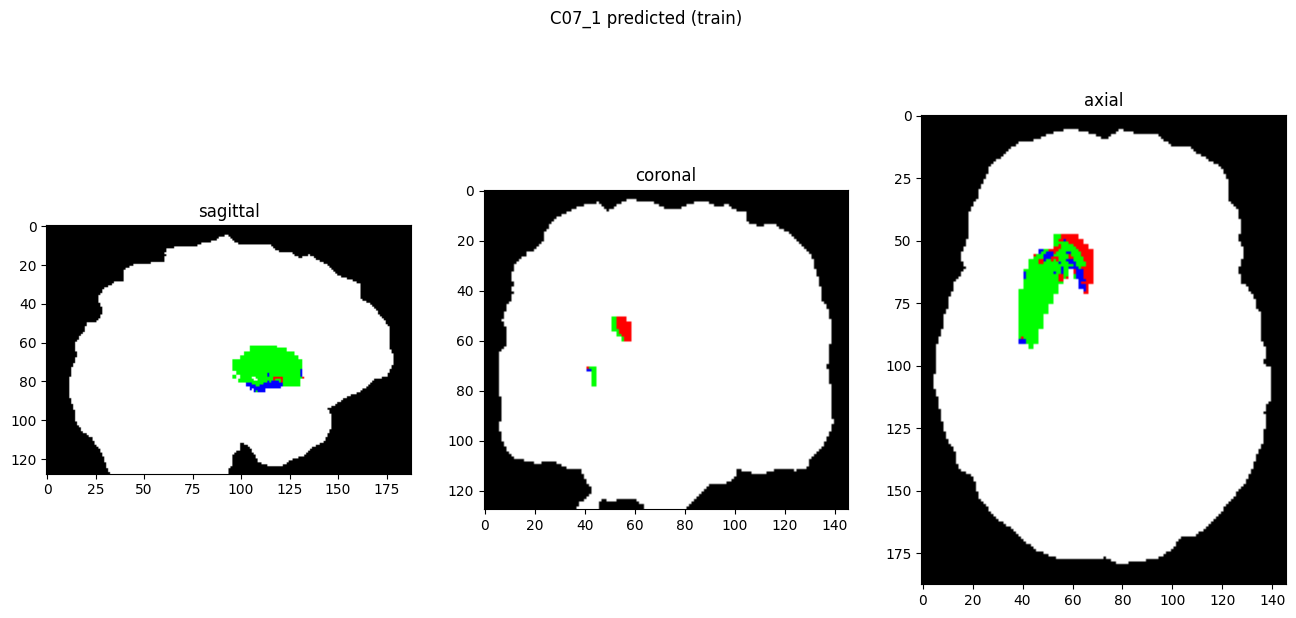

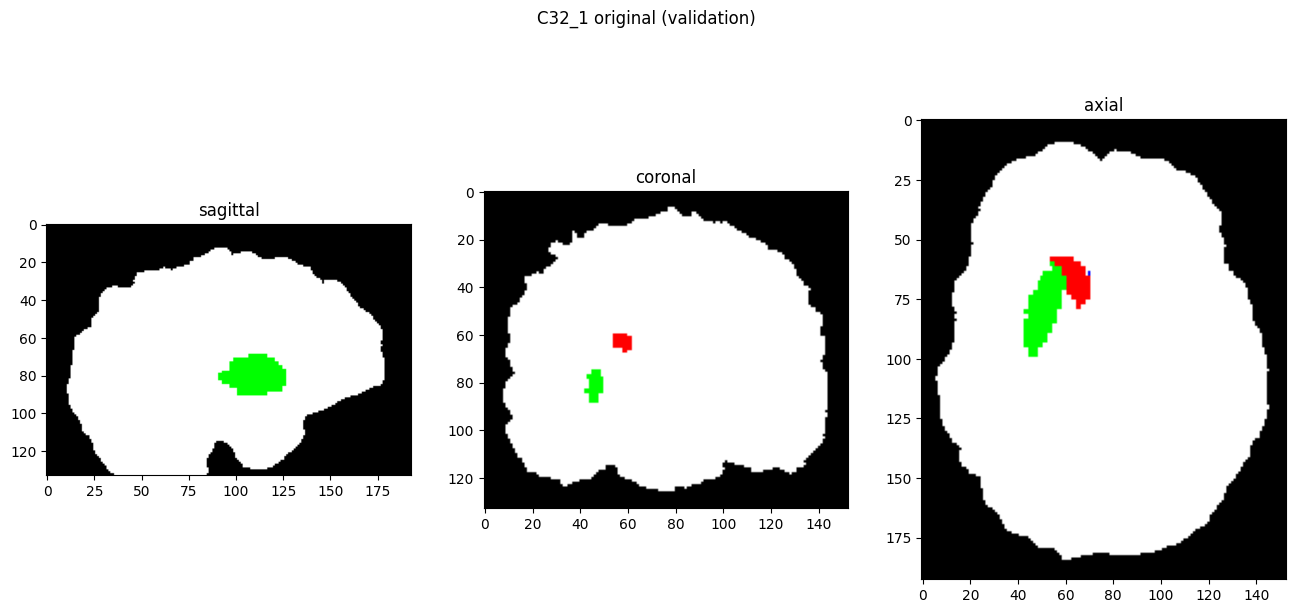

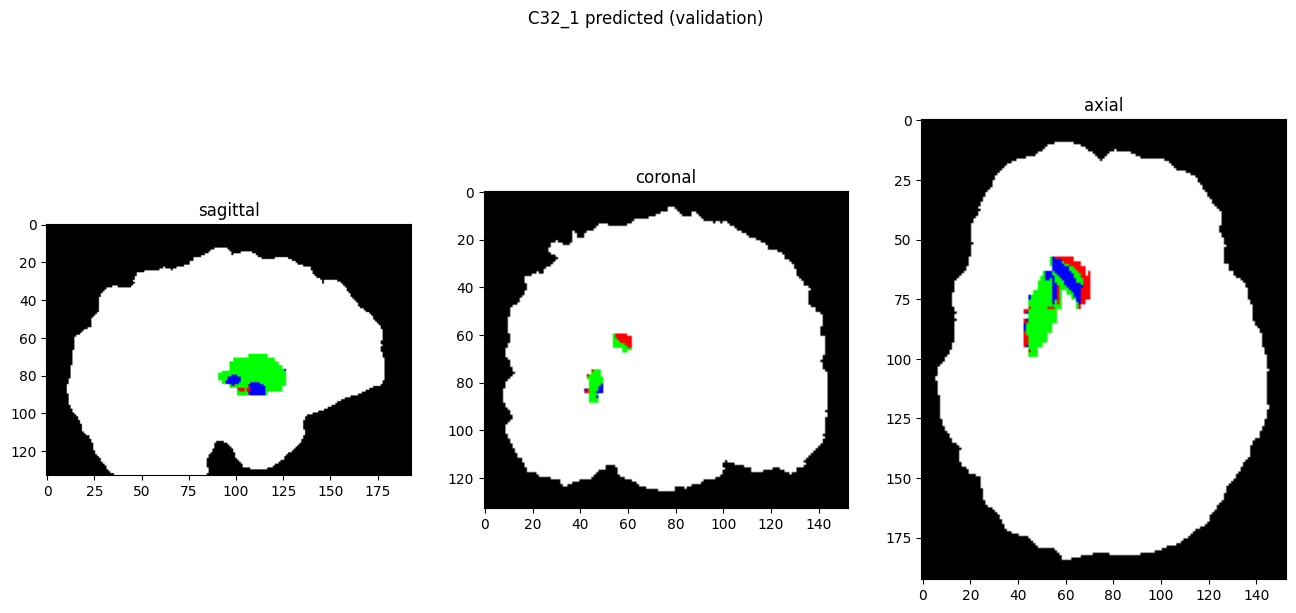

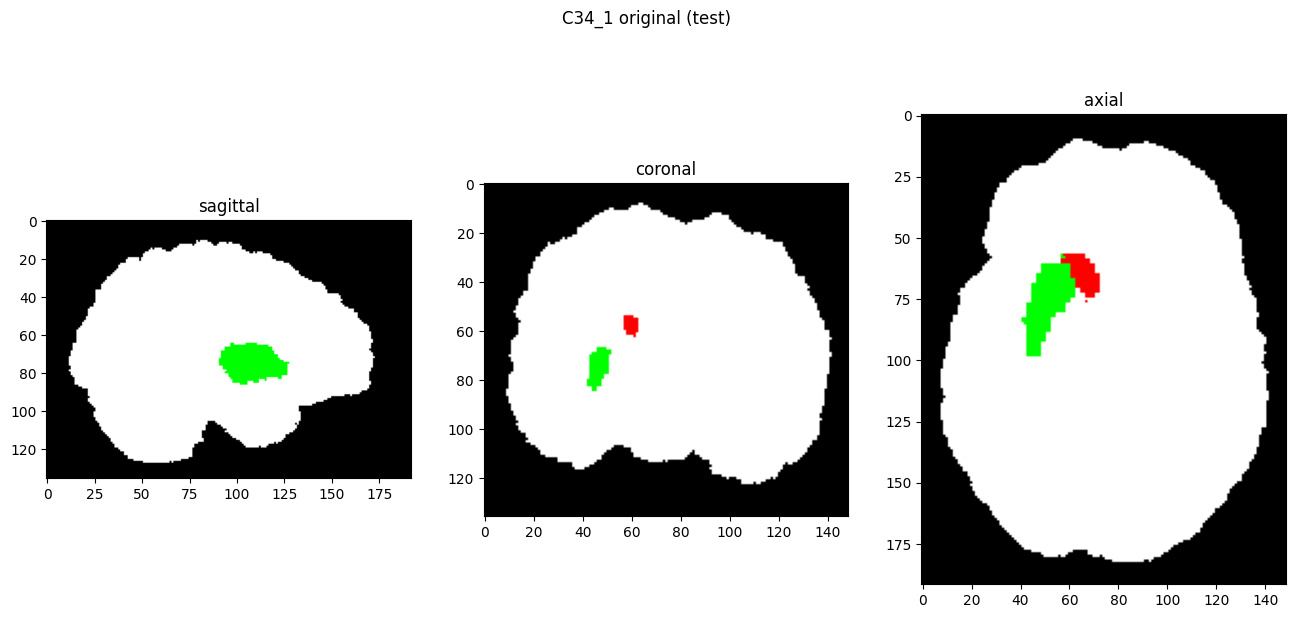

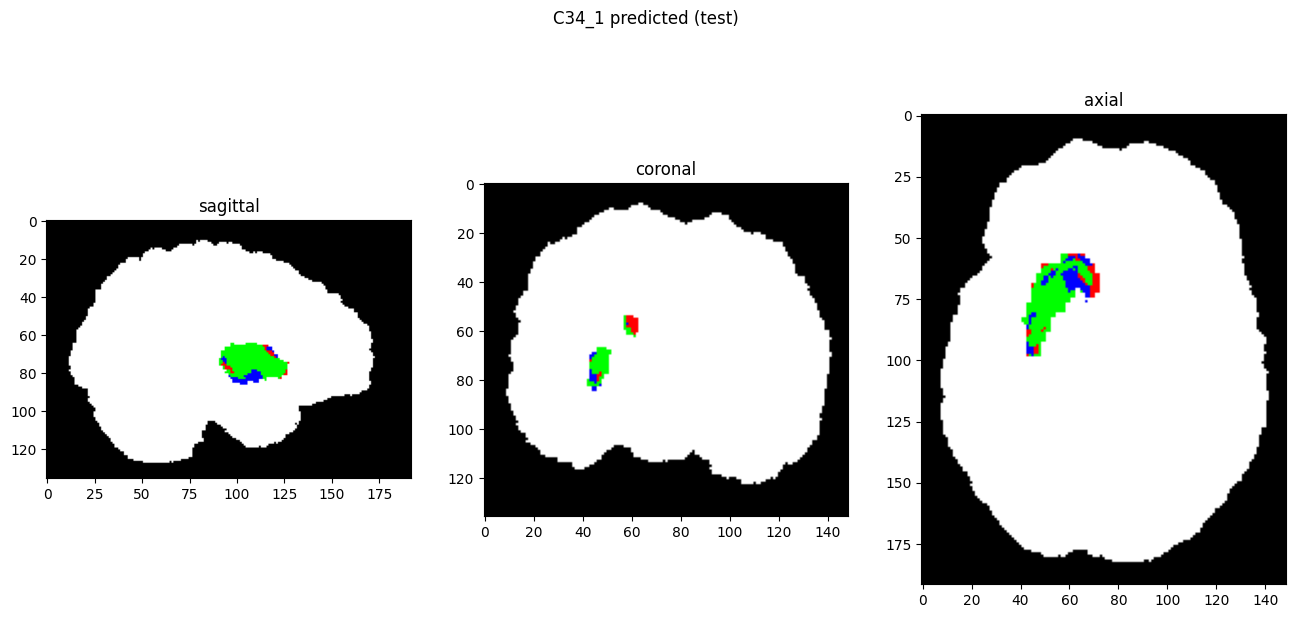

In [9]:
showResults(model, gen, threshold=0)